In [5]:
import sys
import os

sys.path.insert(0, os.path.abspath('../'))

import CtllDes 
from CtllDes.core import ctll, satellite


In [6]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
import astropy as astr
import astropy.units as u
import astropy

In [7]:
from poliastro.bodies import Earth, Sun
from poliastro.frames import Planes
from poliastro.constants import J2000
from poliastro.ephem import Ephem

# Define a function using poliastro utilities in order to obtain the sun-earth vector
this could be added to the library if needed, but I don't think is appropriate since every utility comes from poliastro and astropy libraries.

# Defining specifications and parameters constraints

## <strong>Instruments</strong>

In [8]:
import CtllDes.core.instrument as instr

In [9]:
ROLL_ANGLE = 30*u.deg

### 1st instrument

In [10]:
pixel_width_1 = 28*1E-6*u.m
n_pixels_1 = 3072
sensor_width_1 = n_pixels_1*pixel_width_1
f_length_1 = 17*1E-2*u.m

In [11]:
instr_1 = instr.RollPushBroom(f_length_1, sensor_width_1, ROLL_ANGLE)

### 2nd instrument 

In [12]:
pixel_width_2 = 7*1E-6*u.m
n_pixels_2 = 12288
sensor_width_2 = n_pixels_2*pixel_width_2
f_length_2 = 0.42*u.m

In [13]:
instr_2 = instr.RollPushBroom(f_length_2, sensor_width_2, ROLL_ANGLE)

## <strong>Targets</strong>

In [14]:
from CtllDes.targets.targets import Target, Targets

### 1st instrument targets

In [117]:
bs_as = Targets.from_state("Buenos Aires", N=8)
rio_negro = Targets.from_state("Río Negro", N=11)

### 2nd instrument targets

In [16]:
gba = Targets.from_state("Ciudad de Buenos Aires", N=8) 

cordoba_city = Target.from_city('Córdoba', country='AR')
rosario_city = Target.from_city('Rosario', country='AR')

### <strong>Ground Stations</strong>

In [17]:
MIN_ELEVATION = 15*u.deg
DOWN_RATE = 300*1E6*u.bit/u.s

In [18]:
gs_1 = Target(-64.45, -31.58333)
gs_2 = Target(-58.718, -34.411)

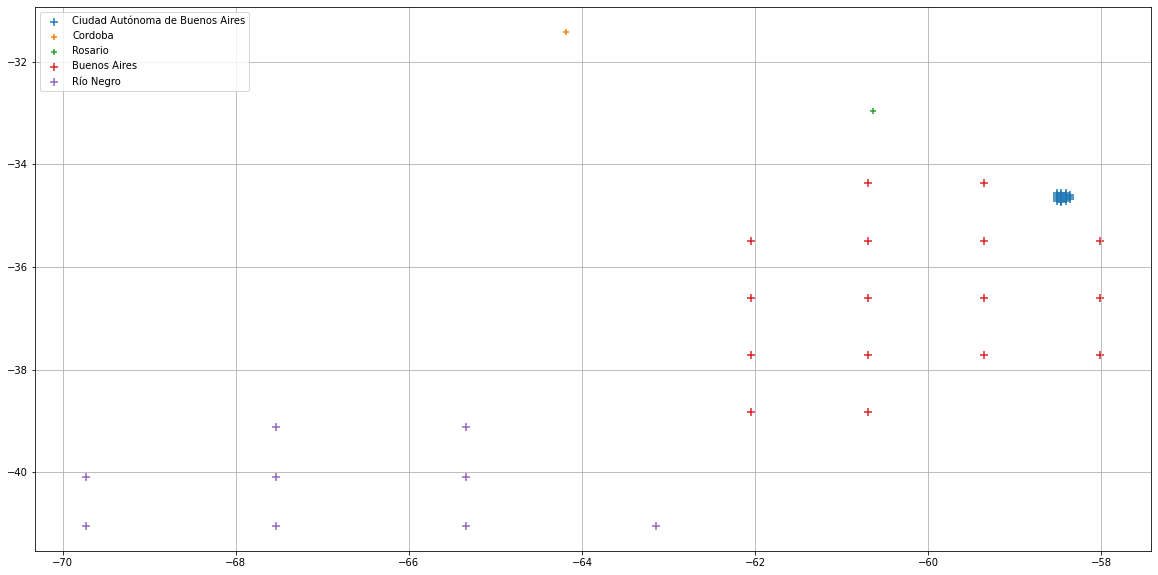

In [19]:
fig = plt.figure(figsize=(20,10))
plt.grid()

plt.scatter(gba.lons,gba.lats,s=50,label='Ciudad Autónoma de Buenos Aires', marker='+')
plt.scatter(cordoba_city.lon,cordoba_city.lat,label='Cordoba', marker='+')
plt.scatter(rosario_city.lon,rosario_city.lat,label='Rosario', marker='+')


plt.scatter(bs_as.lons,bs_as.lats,s=50,label='Buenos Aires', marker='+')
plt.scatter(rio_negro.lons,rio_negro.lats,s=50,label='Río Negro', marker='+')

plt.legend(loc=2)

### <strong>Orbits</strong>

In [20]:
H_MIN = 550*u.km
H_MAX = 650*u.km
MAX_INC = 45*u.deg

R = Earth.R_mean.to(u.km)

R_MIN = R + H_MIN
R_MAX = R + H_MAX

In [21]:
from CtllDes.utils import sscalc

D = 3 #days for revisit
orb_df = sscalc.helio_rgt_synchronous(D) #dataframe
orb_df.head() #radius [km], inclination [degrees], revolutions per day.

,radius,inc,N
0,11549.628629,142.101524,7.000000
1,11196.684826,135.067101,7.333333
2,10869.554031,129.657165,7.666667
3,10565.337007,125.300767,8.000000
4,10281.565346,121.693395,8.333333


In [22]:
filtered_orbits  = orb_df.loc[(orb_df['radius'] > R_MIN.value) & (orb_df['radius'] < R_MAX.value)]
filtered_orbits

,radius,inc,N
24,6947.854468,97.66328,15.0


### Extract semi major axis length = to radius, and inclination.

In [23]:
a = filtered_orbits['radius'].values[0]
a *= u.km
a

<Quantity 6947.85446754 km>

In [24]:
inc = filtered_orbits['inc'].values[0]
inc *= u.deg
inc

<Quantity 97.66328018 deg>

### Define the rest of the classical orbit parameters

In [25]:
ecc = 0*u.one
raan = 0*u.deg # right ascencion of the ascending node [angle]
argp = 0*u.rad # perigee argument [angle]
nu = 0*u.deg # true anomaly [angle] defined as -180 so that it coincides with LTDN

### Build orbit

In [26]:
from poliastro.twobody import Orbit

orb = Orbit.from_classical(Earth,
                            a,
                            ecc,
                            inc,
                            raan,
                            argp,
                            nu)

In [27]:
print(orb.r)
print(orb.v)

[6947.85446754    0.            0.        ] km
[ 0.         -1.01004329  7.50667069] km / s


In [28]:
sat = satellite.Sat.from_orbit(orb)

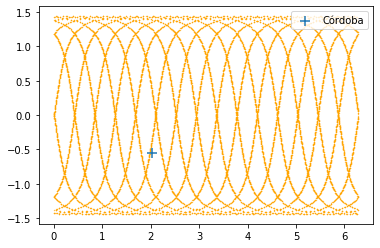

In [29]:
r,v = sat.rv(10,dt=50,J2=True)
lon,lat = sat.ssps_from_r(r,10,dt=50,J2=True)
plt.scatter(lon,lat,s=0.1,c='orange')
plt.scatter(cordoba_city.lon*u.deg.to(u.rad) + 180*u.deg.to(u.rad), cordoba_city.lat*u.deg.to(u.rad),marker='+',label='Córdoba',s=100)
plt.legend(loc=1)

Lets redefine the angle such that LTDN is 12 o'clock solar time 

In [30]:
from CtllDes.utils import trigsf, angles

today = astropy.time.Time({'year': 2021, 'month': 12, 'day': 31,'hour': 12, 'minute': 0, 'second': 0}, scale='utc')
earth_orb = Ephem.from_body(Sun, today.tdb, attractor=Earth)
r0_sun = earth_orb.rv()[0][0].to(u.km)
rr0_sun, lat0_sun, lon0_sun = trigsf.c2s(r0_sun[0],r0_sun[1],r0_sun[2])
lon0_sun.to(u.deg)

<Quantity -79.42945987 deg>

### So the initial raan of the satellite orbit must be such that when $\theta_p+\nu=180\text{°}$ the longitude value in the inertial reference frame is exactly the same as the sun. Therefore

In [31]:
argp = 0*u.deg
nu = 179.9999*u.deg - argp

orb = Orbit.from_classical(Earth, a, ecc, inc, raan, argp, nu)
r0_sat = orb.r
rr0_sat, lat0_sat, lon0_sat = trigsf.c2s(r0_sat[0],r0_sat[1],r0_sat[2])
lon0_sat.to(u.deg)

<Quantity -179.99998666 deg>

### Naturally the initial longitude, if raan is 0 must be the exactly $\nu$, therefore modifying raan by $lon(sun_0)-180°$ we get

In [32]:
raan = lon0_sun-180*u.deg
orb = Orbit.from_classical(Earth, a, ecc, inc, raan, argp, nu)
new_r0_sat = orb.r
_, _, lon0_sat = trigsf.c2s(new_r0_sat[0],new_r0_sat[1],new_r0_sat[2])
lon0_sat.to(u.deg)

<Quantity -79.42944654 deg>

In [33]:
#this has to change names, is not passage raan, is passage offset. 
sat = satellite.Sat.from_orbit(orb)
cordoba_offset = angles.get_passage_raan(sat, (cordoba_city.lon*u.deg).to(u.rad),(cordoba_city.lat*u.deg).to(u.rad))

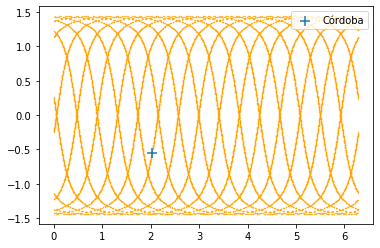

In [34]:
%matplotlib inline
sat = satellite.Sat.from_orbit(orb)
r,v = sat.rv(11,dt=50,J2=True)
lon,lat = sat.ssps_from_r(r,11,dt=50,lon_offset=cordoba_offset,J2=True)
plt.scatter(lon,lat,s=0.1,c='orange')
plt.scatter(cordoba_city.lon*u.deg.to(u.rad) + 180*u.deg.to(u.rad), cordoba_city.lat*u.deg.to(u.rad),marker='+',label='Córdoba',s=100)
plt.legend(loc=1)

## Definitive first reference satm. Instrument 2 Constellation 

In [35]:
ctll_hrgt = ctll.Ctll.from_WalkerDelta(4, 1, 0, orb.a, orb.ecc, orb.inc, orb.argp, raan_offset=orb.raan, nu_offset=nu, instruments=instr_2)

In [36]:
from CtllDes.requests.coverage import Coverages 

## Define time of study and time interval, i.e T=10, dt=20

In [37]:
T=10
ti=20

In [38]:
from CtllDes.utils import sunearth
rsun = sunearth.bodies_vector(T, ti, Earth, Sun, epoch=today)

In [39]:
cov_cordoba = Coverages.from_ctll(ctll_hrgt, cordoba_city, T, dt=ti, r_sun=rsun, lon_offset=cordoba_offset, J2=True)

In [40]:
filtered_cov_cordoba = cov_cordoba.filter_by_sun_angle(np.pi/4)

In [41]:
cov_rosario = Coverages.from_ctll(ctll_hrgt, rosario_city, T, dt=ti, r_sun=rsun, lon_offset=cordoba_offset, verbose = False)

In [42]:
cov_rosario_filtered = cov_rosario.filter_by_sun_angle(np.pi/4).collapse_sats()

In [ ]:
cov_baires_ctll_hrgt = Coverages.from_ctll(ctll_hrgt, bs_as, T, dt=ti, r_sun=rsun, lon_offset=cordoba_offset, verbose=True, J2=True)

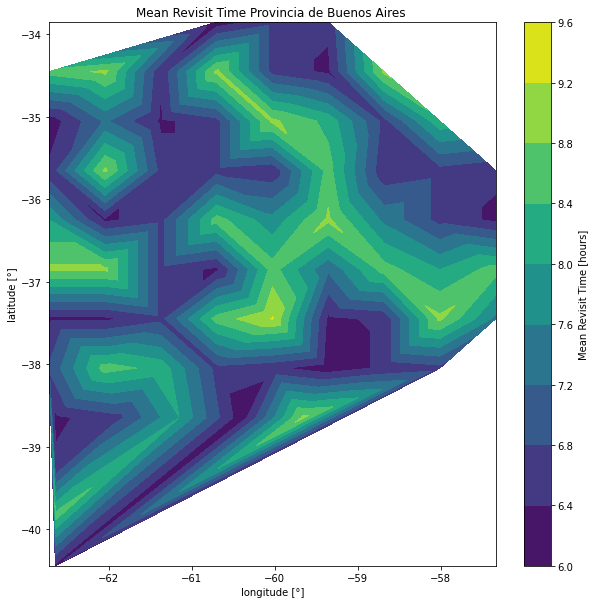

In [119]:
plot_Targets_merit(cov_baires_ctll_hrgt.collapse_sats().to_df(), bs_as, target_name = 'Provincia de Buenos Aires', accumulated=False, response=False,
                  average_time_gap=False)

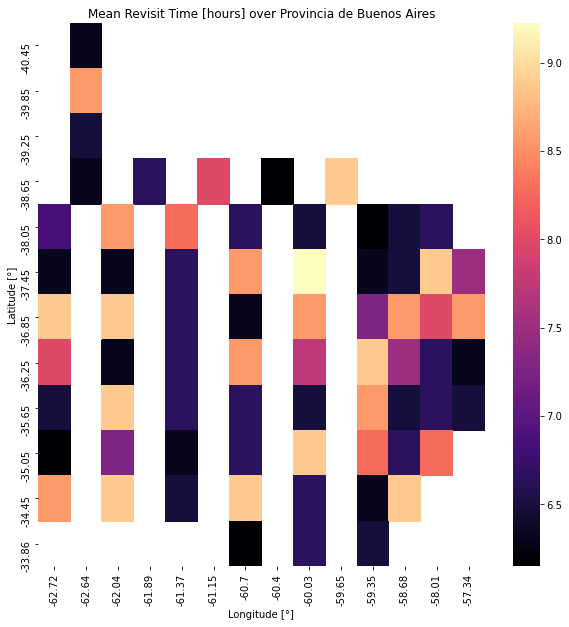

In [128]:
plot_heat_map(cov_baires_ctll_hrgt.collapse_sats().to_df(), bs_as, target_name = 'Provincia de Buenos Aires', accumulated=False, response=False,
                  average_time_gap=False)

In [45]:
new_baires = cov_baires_ctll_hrgt.filter_by_sun_angle(np.pi/4)

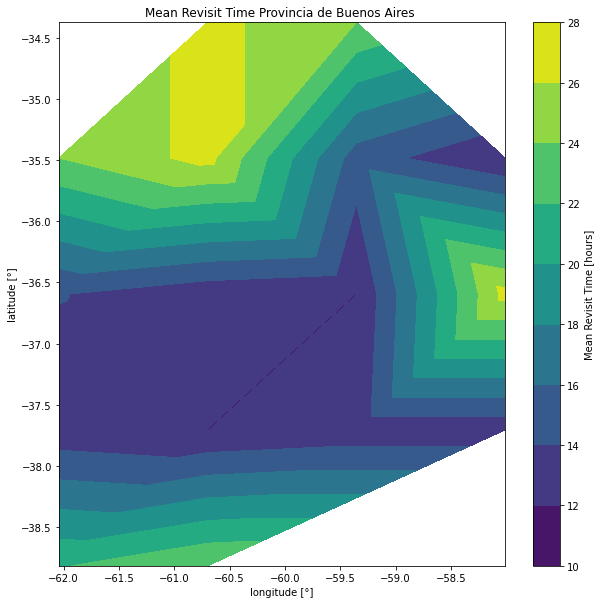

In [89]:
plot_Targets_merit(new_baires.collapse_sats().to_df(), bs_as, target_name = 'Provincia de Buenos Aires', accumulated=False, response=False,
                  average_time_gap=False)

In [ ]:
cov_rio_negro_ctll_hrgt = Coverages.from_ctll(ctll_hrgt, rio_negro, T, dt=ti, r_sun=rsun, verbose=True, J2=True)

In [127]:
plot_Targets_merit(cov_rio_negro_ctll_hrgt.collapse_sats().to_df(), rio_negro, target_name = 'Provincia de Río Negro', accumulated=False, response=False,
                  average_time_gap=False)

NameError: name 'cov_rio_negro_ctll_hrgt' is not defined

In [53]:
new_rio_negro = cov_rio_negro_ctll_hrgt.filter_by_sun_angle(np.pi/4)

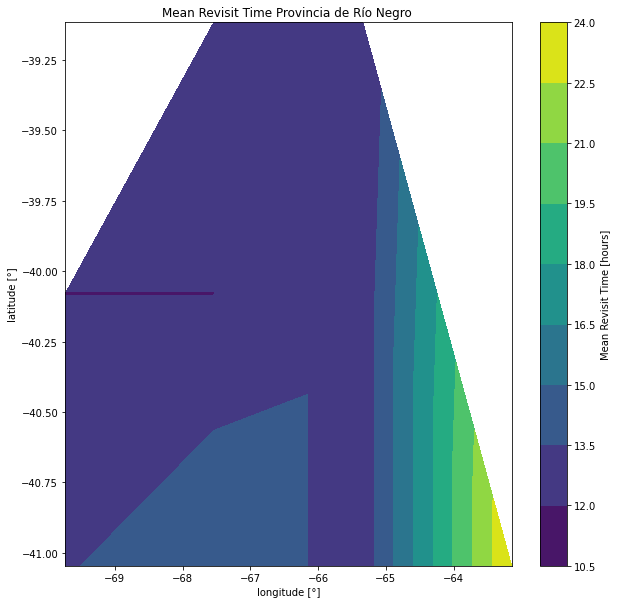

In [54]:
plot_Targets_merit(new_rio_negro.collapse_sats().to_df(), rio_negro, target_name = 'Provincia de Río Negro', accumulated=False, response=False,
                  average_time_gap=False)

In [55]:
cov_gba = Coverages.from_ctll(ctll_hrgt, gba, T, ti, r_sun=rsun, lon_offset=cordoba_offset, J2=True)

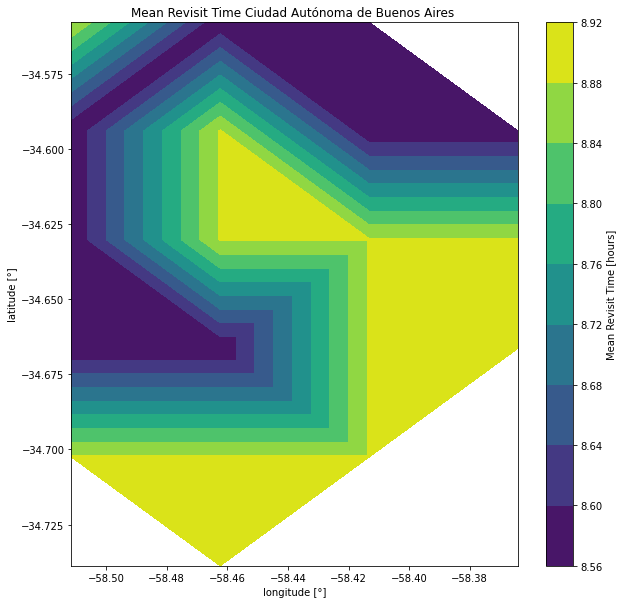

In [56]:
plot_Targets_merit(cov_gba.collapse_sats().to_df(), gba, target_name='Ciudad Autónoma de Buenos Aires',
                  response=False, average_time_gap=False,accumulated=False)

In [57]:
cov_gba_filtered = cov_gba.filter_by_sun_angle(np.pi/4)

In [58]:
collapsed_cov_gba = cov_gba_filtered.collapse_sats().to_df()

In [ ]:
collapsed_cov_gba

<ipython-input-46-e104a634f7d4>:12: RuntimeWarning: invalid value encountered in true_divide
  response_time /= max(response_time)
<ipython-input-46-e104a634f7d4>:17: RuntimeWarning: invalid value encountered in true_divide
  roll_avg /= max(roll_avg)


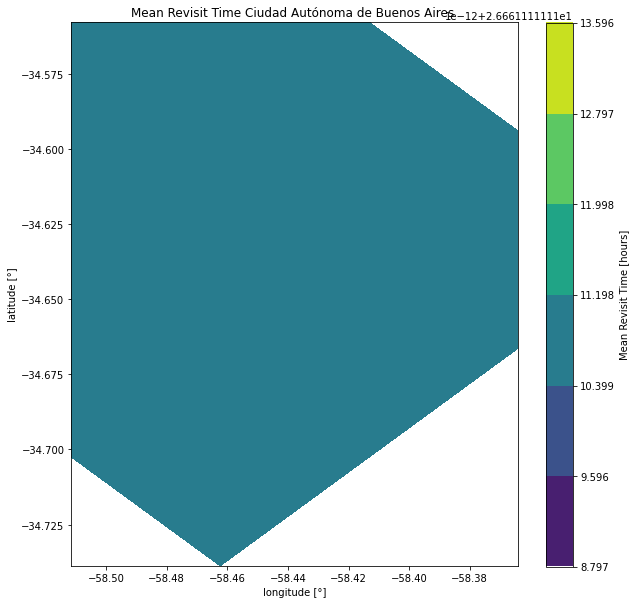

In [60]:
plot_Targets_merit(collapsed_cov_gba, gba, target_name='Ciudad Autónoma de Buenos Aires',
                  response=False, average_time_gap=False, accumulated=False)

# Instrument 1 Constellation

In [61]:
orb_ctll_li_1 = Orbit.from_classical(Earth, a, ecc, 45*u.deg, raan+10*u.deg, argp, nu)
orb_ctll_li_2 = Orbit.from_classical(Earth, a, ecc, 45*u.deg, raan+10*u.deg, argp, nu-15*u.deg)

In [62]:
sat_1_li = satellite.Sat.from_orbit(orb_ctll_li_1, instruments=instr_1)
sat_2_li = satellite.Sat.from_orbit(orb_ctll_li_2, instruments=instr_1)

In [63]:
ctll_li = ctll.Ctll.from_sats([sat_1_li, sat_2_li], pattern=[{'PAT':'Low inclination', 'N':2}])

In [64]:
cov_cordoba_ctll_li = Coverages.from_ctll(ctll_li, cordoba_city, T, dt=ti, r_sun=rsun, lon_offset=cordoba_offset, J2=True)
cov_rosario_ctll_li = Coverages.from_ctll(ctll_li, rosario_city, T, dt=ti, r_sun=rsun, lon_offset=cordoba_offset, J2=True)

cov_gba_ctll_li = Coverages.from_ctll(ctll_li, gba, T, dt=ti, r_sun=rsun, lon_offset=cordoba_offset, verbose=True, J2=True)
cov_baires_ctll_li = Coverages.from_ctll(ctll_li, bs_as, T, dt=ti, r_sun=rsun, lon_offset=cordoba_offset, verbose=True, J2=True)
cov_rio_negro_ctll_li = Coverages.from_ctll(ctll_li, rio_negro, T, dt=ti, r_sun=rsun, lon_offset=cordoba_offset, verbose=True, J2=True)

target -67.54° -39.12°. 8 of 9
target -65.34° -39.12°. 9 of 9


In [65]:
new_cov_gba_ctll_li = cov_gba_ctll_li.filter_by_sun_angle(np.pi/4).collapse_sats()
new_cov_baires_ctll_li = cov_baires_ctll_li.filter_by_sun_angle(np.pi/4).collapse_sats()
new_cov_rio_negro_ctll_li = cov_rio_negro_ctll_li.filter_by_sun_angle(np.pi/4).collapse_sats()

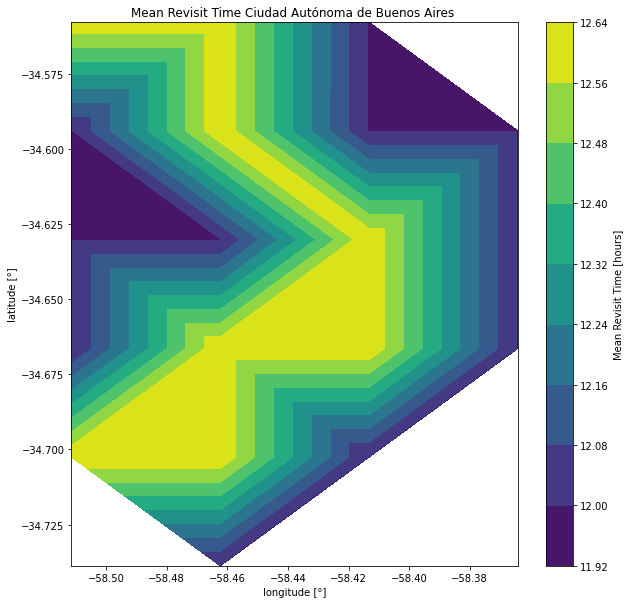

In [66]:
plot_Targets_merit(new_cov_gba_ctll_li.to_df(), gba, target_name="Ciudad Autónoma de Buenos Aires", accumulated=False, response=False, average_time_gap=False)

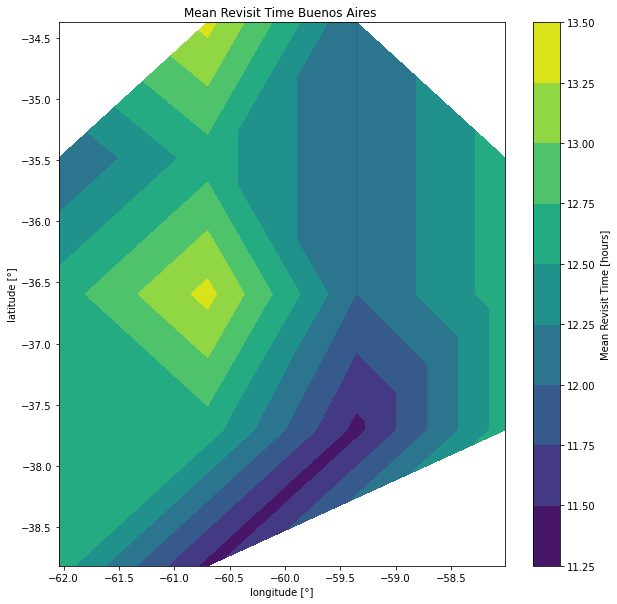

In [67]:
plot_Targets_merit(new_cov_baires_ctll_li.to_df(), bs_as, target_name="Buenos Aires", accumulated=False, response=False, average_time_gap=False)

In [78]:
plot_Targets_merit(new_cov_rio_negro_ctll_li.to_df(), rio_negro, target_name="Rio Negro", accumulated=False, response=False, average_time_gap=False)

ModuleNotFoundError: No module named 'seaborn'

<Figure size 720x720 with 0 Axes>

In [69]:
from CtllDes.requests import comm

ctll_hrgt.sats_id

[UUID('25697053-f1ee-4d31-9511-ed2b2a953bc7'),
 UUID('b724ff11-5422-42ae-8c7b-bc16f7f9eb74'),
 UUID('f2a0e47e-b9c2-4020-9947-9580db1d0065'),
 UUID('b2a2ce42-b235-4789-be66-90b3beaae957')]

In [70]:
desired_id = ctll_hrgt.sats_id[1]
desired_sat = ctll_hrgt.get_sat(desired_id)
desired_sat

# Ground Stations

In [71]:
benavidez = Target(-58.718, -34.411)
FDC = Target(-64.43, -31.5833)

In [72]:
desired_comm_data_benavidez = comm.default_comm_data(desired_sat, benavidez, T, dt=ti, J2=True)
desired_comm_data_FDC = comm.default_comm_data(desired_sat, FDC, T, dt=ti, J2=True)

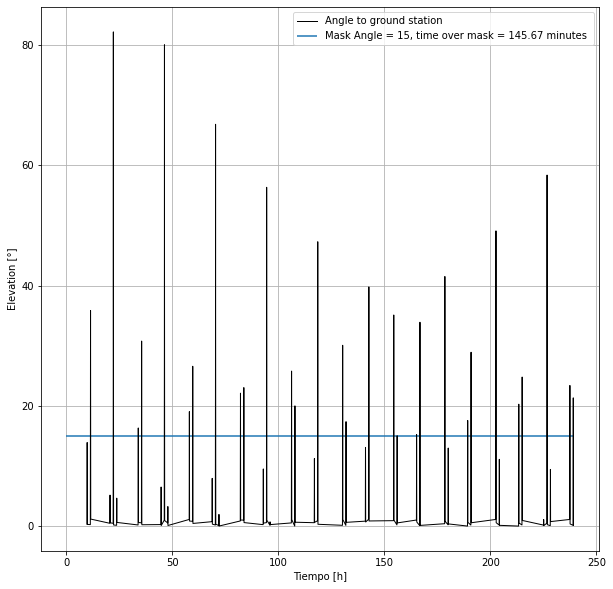

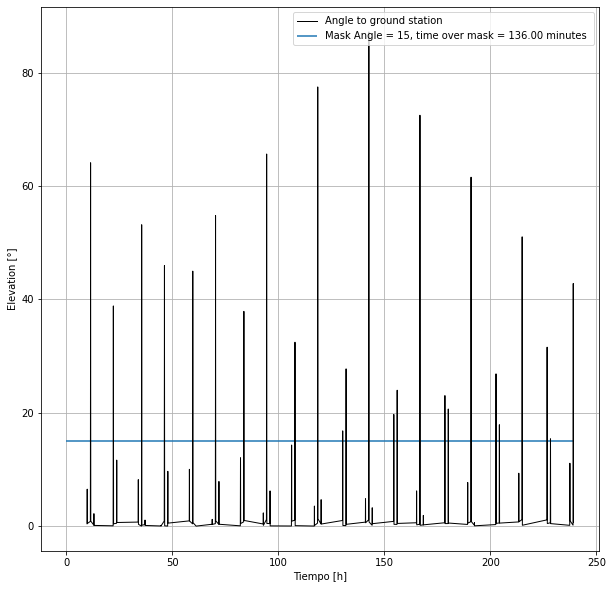

In [75]:
plot_comm(desired_comm_data_benavidez, mask=15, deg=True, total_time=True)
plot_comm(desired_comm_data_FDC, mask=15, deg=True, total_time=True)

In [76]:
(DOWN_RATE*145.67*60*u.s).to(u.terabyte)

<Quantity 0.3277575 Tbyte>

In [74]:
def plot_comm(comm_df, mask = None, deg=False, total_time=False):
    if not deg:
        elevation = comm_df['elevation'].to_numpy(dtype=np.float64)
    else:
        elevation = comm_df['elevation'].to_numpy(dtype=np.float64)*180/np.pi
    
    time = comm_df['time']/3600
    
    fig, ax = plt.subplots(figsize=(10,10))
    ax.plot(time, elevation, linewidth=1, color='black', label='Angle to ground station')
    ax.grid()
    if mask != None:
        elevation_mask = [e for e in elevation if e > mask]
        time_over = len(elevation_mask)*(time[1]-time[0])*3600 #very nasty

        if not deg:
            ax.hlines(mask, xmin=0, xmax=max(time), label=f'Mask Angle = {mask}, time over mask = {time_over/60:.2f} minutes')
        else:
            ax.hlines(mask, xmin=0, xmax=max(time),label=f'Mask Angle = {mask}, time over mask = {time_over/60:.2f} minutes ')
            
    ax.set_xlabel("Tiempo [h]")
    if not deg:
        ax.set_ylabel("Elevation [rad]")
    else:
        ax.set_ylabel("Elevation [°]")        
    
    ax.legend(loc=1)

In [3]:
from itertools import groupby
import time

test_cov_rle = np.array([[k, sum(1 for i in g)] for k,g in groupby(test_cov.cov)])
t = time.time()
gap = 0

for i in test_cov_rle:
    if i[0] == 0:
        gap+=0
    else:
        pass
        
print(f"Took {time.time()-t} seconds")
test_cov_rle

NameError: name 'np' is not defined

In [ ]:
# chequera walkerdelta

In [ ]:
covsat=[]
for i in np.linspace(1, 200, 100):
    t = time.time()
    covsat.append(Coverages.from_sat(ctll_hrgt.sats[2], cordoba_city, 3, dt=i, lon_offset=cordoba_offset,
                         verbose=True, J2=True))
    print(time.time()-t)


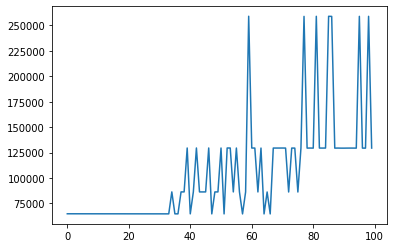

In [193]:

mean_gap_dark_sat = [_.to_df()['mean gap dark'].to_numpy(dtype=np.float64) for _ in covsat]
plt.plot( mean_gap_dark_sat)

,T,dt,Satellite ID,Target,accumulated,mean gap light,mean gap dark,response time,average time gap,max gap,sun angle
0,3,57.282828,43616fe4-b099-4a46-b1fc-a9521f0b3108,"(-64.1833, -31.4167)",171.848485,57.282828,64729.59596,42391.838551,84726.432269,86325.222222,None


In [125]:
def plot_heat_map(rollcovdf,
                  tgts,
                  target_name = 'Not specified',
                  accumulated=True,
                  response=True,
                  average_time_gap=True,
                  revisit=True):
    
    target_lons = np.round(tgts.lons, decimals=2)
    target_lats = np.round(tgts.lats, decimals=2)

    roll_accum = rollcovdf['accumulated'].to_numpy(dtype=float)/3600
    #roll_accum /= max(roll_accum)

    response_time = rollcovdf['response time'].to_numpy()/3600
    response_time = 1/response_time
    response_time -= min(response_time)
    response_time /= max(response_time)
        
    roll_avg = rollcovdf['average time gap'].to_numpy(dtype=float)/3600
    roll_avg = 1/roll_avg
    roll_avg -= min(roll_avg)
    roll_avg /= max(roll_avg) 
    
    revisit_time = rollcovdf['mean gap dark'].to_numpy(dtype=np.float64)/3600
        
    if accumulated:
        fig = plt.figure(figsize=(10,10))
        ax = plt.axes()
        
        df = pd.DataFrame.from_dict(np.array([target_lons,target_lats,roll_accum]).T)
        df.columns = ['Longitude [°]','Latitude [°]','Accumulated time of view [hours]']
        df['Accumulated time of view [hours]'] = pd.to_numeric(df['Accumulated time of view [hours]'])
        pivotted= df.pivot('Latitude [°]','Longitude [°]','Accumulated time of view [hours]')
        sns.heatmap(pivotted, cmap='magma', ax=ax)
        ax.set_title(f"Accumulated time of view over {target_name}")

    if response:
        fig = plt.figure(figsize=(10,10))
        ax = plt.axes()
        
        df = pd.DataFrame.from_dict(np.array([target_lons,target_lats,response_time]).T)
        df.columns = ['Longitude [°]','Latitude [°]','Mean Response Time [1/hours]']
        df['Mean Response Time [1/hours]'] = pd.to_numeric(df['Mean Response Time [1/hours]'])
        pivotted= df.pivot('Latitude [°]','Longitude [°]','Mean Response Time [1/hours]')
        sns.heatmap(pivotted, cmap='magma', ax=ax)
        ax.set_title(f"Mean Response Time [1/hours] over {target_name}")

    if revisit:
        fig = plt.figure(figsize=(10,10))
        ax = plt.axes()
        
        df = pd.DataFrame.from_dict(np.array([target_lons,target_lats,revisit_time]).T)
        df.columns = ['Longitude [°]','Latitude [°]','Mean Revisit Time [hours]']
        df['Mean Revisit Time [hours]'] = pd.to_numeric(df['Mean Revisit Time [hours]'])
        pivotted= df.pivot('Latitude [°]','Longitude [°]','Mean Revisit Time [hours]')
        sns.heatmap(pivotted, cmap='magma', ax=ax)
        ax.set_title(f"Mean Revisit Time [hours] over {target_name}")        

    if average_time_gap:
        fig = plt.figure(figsize=(10,10))
        ax = plt.axes()
        
        df = pd.DataFrame.from_dict(np.array([target_lons,target_lats,roll_accum]).T)
        df.columns = ['Longitude [°]','Latitude [°]','Average Time Gap [1/hours]']
        df['Average Time Gap [1/hours]'] = pd.to_numeric(df['Average Time Gap [1/hours]'])
        pivotted= df.pivot('Latitude [°]','Longitude [°]','Average Time Gap [1/hours]')
        sns.heatmap(pivotted, cmap='magma', ax=ax)
        ax.set_title(f"Average Time Gap [1/hours] over {target_name}")

In [87]:
def plot_Targets_merit(rollcovdf,
                       tgts,
                       target_name = 'Not specified',
                       accumulated=True,
                       response=True,
                       average_time_gap=True,
                       revisit=True,
                       use_3d=False):
    
    target_lons = tgts.lons
    target_lats = tgts.lats

    roll_accum = rollcovdf['accumulated'].to_numpy(dtype=float)/3600
    #roll_accum /= max(roll_accum)

    response_time = rollcovdf['response time'].to_numpy()/3600
    response_time = 1/response_time
    response_time -= min(response_time)
    response_time /= max(response_time)
        
    roll_avg = rollcovdf['average time gap'].to_numpy(dtype=float)/3600
    roll_avg = 1/roll_avg
    roll_avg -= min(roll_avg)
    roll_avg /= max(roll_avg) 
    
    revisit_time = rollcovdf['mean gap dark'].to_numpy(dtype=np.float64)/3600
        
    if accumulated:
        fig = plt.figure(figsize=(10,10))
        
        if use_3d:
            ax.plot_trisurf(target_lons, target_lats, roll_accum,
                       antialiased=False, cmap='afmhot')
            ax.scatter(target_lons,target_lats, np.zeros(len(target_lons)),
                   s=100,c='k')
        else:
            ax = plt.axes()
            tcs = ax.tricontourf(target_lons, target_lats, roll_accum)
            cb = plt.colorbar(tcs)
            cb.ax.set_ylabel("Accumulated time of view [hours]")

        
        ax.set_title(f"Accumulated time of view for {target_name} ")
        
        ax.set_xlabel("longitude [°]")
        ax.set_ylabel("latitude [°]")
        if use_3d:
            ax = fig.add_subplot(projection='3d')
            ax.set_zlabel("Accumulated time of view [hours]")
            
        ax.set_xlim(min(target_lons),max(target_lons))
        ax.set_ylim(min(target_lats),max(target_lats))


        
    if response:
        fig = plt.figure(figsize=(10,10))
        
        if use_3d:
            ax = fig.add_subplot(projection='3d')
            ax.plot_trisurf(target_lons, target_lats, response_time,
                       antialiased=False, cmap='afmhot')
            ax.scatter(target_lons,target_lats, np.zeros(len(target_lons)),
                   s=100,c='k')
        else:
            ax = plt.axes()
            tcs = ax.tricontourf(target_lons, target_lats, response_time)
            cb = plt.colorbar(tcs)
            cb.ax.set_ylabel("Respose time [1/hours]")
            
        ax.set_title(f"Response Time for {target_name} ")
        
        ax.set_xlabel("longitude [°]")
        ax.set_ylabel("latitude [°]")
        if use_3d:
            ax.set_zlabel("Respose time [1/hours]")
            
        ax.set_xlim(min(target_lons),max(target_lons))
        ax.set_ylim(min(target_lats),max(target_lats))
        

        
    if average_time_gap:        
        fig = plt.figure(figsize=(10,10))
        
        if use_3d:
            ax = fig.add_subplot(projection='3d')
            ax.plot_trisurf(target_lons, target_lats, roll_avg,
                       antialiased=False, cmap='afmhot')
            ax.scatter(target_lons,target_lats, np.zeros(len(target_lons)),
                   s=100,c='k')
        else:
            ax = plt.axes()
            tcs = ax.tricontourf(target_lons, target_lats, roll_avg)
            cb = plt.colorbar(tcs)
            cb.ax.set_ylabel("Average time Gap for [1/hours]")

        ax.set_title(f"Average time Gap for {target_name} ")
        
        ax.set_xlabel("longitude [°]")
        ax.set_ylabel("latitude [°]")
        if use_3d:
            ax.set_zlabel("Average time Gap for [1/hours]")
            
        ax.set_xlim(min(target_lons),max(target_lons))
        ax.set_ylim(min(target_lats),max(target_lats))
        

       
    if revisit:
        fig = plt.figure(figsize=(10,10))
        
        if use_3d:
            ax = fig.add_subplot(projection='3d')
            ax.plot_trisurf(target_lons, target_lats, revisit_time,
                       antialiased=False, cmap='afmhot')
            ax.scatter(target_lons,target_lats, np.zeros(len(target_lons)),
                   s=100,c='k')
        else:
            ax = plt.axes()
            tcs = ax.tricontourf(target_lons, target_lats, revisit_time)
            cb = plt.colorbar(tcs)
            cb.ax.set_ylabel("Mean Revisit Time [hours]")
        
        ax.set_title(f"Mean Revisit Time {target_name} ")
        
        ax.set_xlabel("longitude [°]")
        ax.set_ylabel("latitude [°]")
        if use_3d:
            ax.set_zlabel("Mean Revisit Time [hours]")
            
        ax.set_xlim(min(target_lons),max(target_lons))
        ax.set_ylim(min(target_lats),max(target_lats))

